In [5]:
import cv2
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

import torchvision 
import matplotlib.patches as patches

from skimage import data, img_as_float
from skimage import exposure
import skimage
from skimage.color import rgb2gray
from skimage import data, color, img_as_ubyte
from skimage.feature import canny
from skimage.transform import hough_ellipse
from skimage.draw import ellipse_perimeter
 
from bubbleDetection.ellipseRecognize import DTECMA

In [6]:
def load_image(idx, transform = None):
    filename = f"data/image/haima/out-{str(idx).zfill(2)}.png"
    img = Image.open(filename)
    img = np.array(img)
    if transform: img = transform(img)
    return img

def transform_crop(img, crop=(1820, 0, 2420, 400)):
    # image crop
    img = img[crop[1] : crop[3], crop[0]: crop[2]]
    return img

def transform_equalization(img, crop=(1820, 0, 2420, 400)): 
    # Equalization
    img = img[crop[1] : crop[3], crop[0]: crop[2]]
    img = exposure.equalize_hist(img)
    return img

def transform_binimg(img, crop = (1820, 0, 2420, 400), threshold=0.8): 
    
    # image crop
    img = img[crop[1] : crop[3], crop[0]: crop[2]]

    # Equalization
    img = np.array(img)
    img = exposure.equalize_hist(img)

    # # convert to gray 
    img = np.dot(img, [0.2989, 0.5870, 0.1140])

    # # thresholding
    img[img < threshold] = 0 
    img[img >= threshold] = 255

    return img.astype(np.uint8)

def transform_cc(img, crop = (1820, 0, 2420, 400), bin_threshold=0.8, cc_area_th=100):
        # image crop
    img = img[crop[1] : crop[3], crop[0]: crop[2], :]
    h, w = img.shape[:2]

    # Equalization
    img = np.array(img)
    img = exposure.equalize_hist(img)

    #  convert to gray 
    img = np.dot(img, [0.2989, 0.5870, 0.1140])

    # thresholding
    img[img < bin_threshold] = 0 
    img[img >= bin_threshold] = 255
    img = img.astype(np.uint8)

    # keep satisfied connected component 
    cca_output = cv2.connectedComponentsWithStats(img, connectivity=8)
    cc_label = set() 
    num_labels, labels, stats, centroids = cca_output
    for idx, (_, _, _, _, area) in enumerate(stats[1:], start=1): 
        if area  > cc_area_th: 
            cc_label.add(idx)  
    for i in range(h): 
        for j in range(w): 
            if labels[i][j] in cc_label: 
                img[i][j] = 255
            else: 
                img[i][j] = 0 

    # flood filling 
    flood_img = img.copy()
    mask = np.ones((h+2, w+2), np.uint8) * 0
    cv2.floodFill(flood_img, mask, (0, 0), 255)
    floodfill_inv = cv2.bitwise_not(flood_img)
    img |= floodfill_inv

    return img

In [7]:
def binimg_bubble_detector(binimg, threshold=100):       
      
    cca_output = cv2.connectedComponentsWithStats(binimg, connectivity=8)
    ans = []
    num_labels, labels, stats, centroids = cca_output
    for x, y, w, h, area in stats[1:]: 
        if area  > threshold: 
            ans.append((x, y, w, h))
    return ans

def binimg_circle_detector(img): 
    circles = cv2.HoughCircles(img, cv2.cv.CV_HOUGH_GRADIENT, 1, minDist=15,
                     param1=50, param2=18, minRadius=12, maxRadius=22)

c:\Users\shuduo\miniconda3\envs\pytorch\Lib\site-packages\skimage\_shared\utils.py:438: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel, or set channel_axis.
  return func(*args, **kwargs)


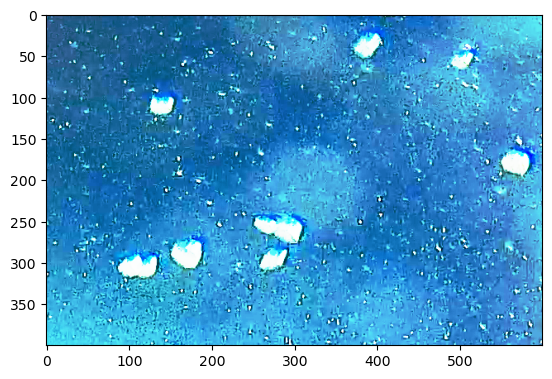

In [8]:
img = load_image(1, transform=transform_equalization)
plt.imshow(img)

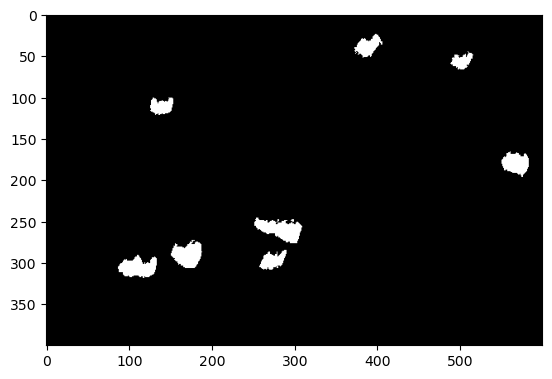

In [9]:
img = load_image(1, transform=transform_cc)
plt.imshow(img, cmap=plt.cm.gray)


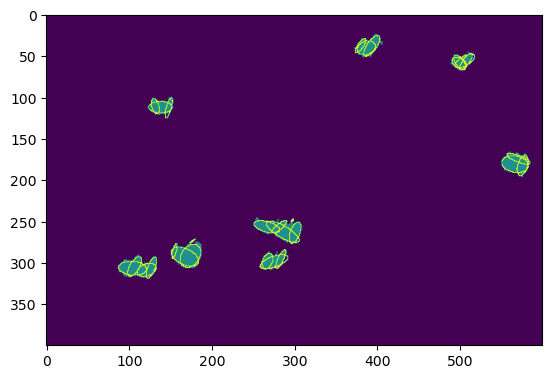

In [10]:

ellipses, output = DTECMA(img, lam = 0.75)
plt.imshow(output)

c:\Users\shuduo\miniconda3\envs\pytorch\Lib\site-packages\skimage\_shared\utils.py:438: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel, or set channel_axis.
  return func(*args, **kwargs)


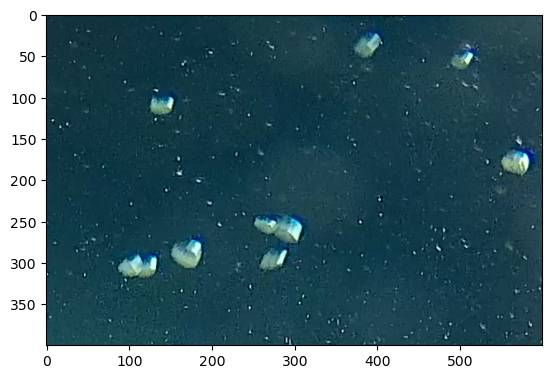

In [13]:
for idx in range(1, 2): 

    # load image
    img_raw = load_image(idx, transform=transform_crop)
    img = load_image(idx, transform=transform_binimg)

    # perform detection
    cc = binimg_bubble_detector(img)

    # display result
    fig, ax = plt.subplots()
    ax.imshow(img_raw)
    # for c in cc: 
    #     rect = patches.Rectangle(c[:2], c[2], c[3], linewidth=1, edgecolor='r', facecolor='none')
    #     ax.add_patch(rect) 
    plt.show()

In [ ]:
def plot_img_and_hist(image, axes, bins=256):
    """Plot an image along with its histogram and cumulative histogram."""
    image = img_as_float(image)
    ax_img, ax_hist = axes
    ax_cdf = ax_hist.twinx()

    # Display image
    ax_img.imshow(image, cmap=plt.cm.gray)
    ax_img.set_axis_off()

    # Display histogram
    ax_hist.hist(image.ravel(), bins=bins, histtype='step', color='black')
    ax_hist.ticklabel_format(axis='y', style='scientific', scilimits=(0, 0))
    ax_hist.set_xlabel('Pixel intensity')
    ax_hist.set_xlim(0, 1)
    ax_hist.set_yticks([])

    # Display cumulative distribution
    img_cdf, bins = exposure.cumulative_distribution(image, bins)
    ax_cdf.plot(bins, img_cdf, 'r')
    ax_cdf.set_yticks([])

    return ax_img, ax_hist, ax_cdf

[(201, 120, 25, 24),
 (318, 161, 27, 31),
 (155, 236, 32, 31),
 (584, 237, 16, 18),
 (234, 302, 32, 29),
 (23, 381, 29, 19),
 (85, 385, 30, 15)]

In [ ]:
img = skimage.io.imread('./data/image/haima-optical-img.jpg')
crop_window = np.array([1820, 0, 600, 400])                   # format [x, y, w, h]
[row, col] = skimage.draw.rectangle_perimeter(start= crop_window[0:2], end = crop_window[0:2] + crop_window[2:])
img_copy = img.copy() 
img_copy[row, col] = 1
crop_img = img[crop_window[0][0]:crop_window[1][0],  crop_window[0][1]:crop_window[1][1], :]

plt.imshow(crop_img) 
skimage.io.imsave("crop_img.png", crop_img)

IndexError: index 2160 is out of bounds for axis 0 with size 2160

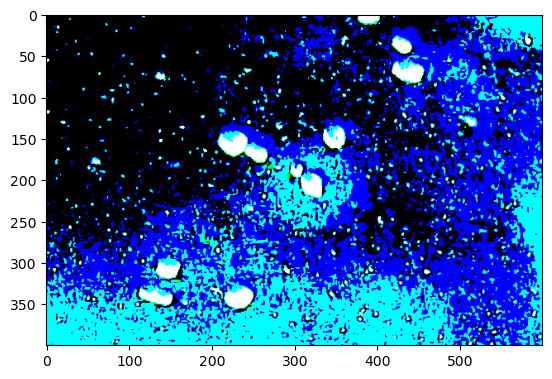

In [ ]:

# Guassian blur to smooth image
bubble_frame_blur = cv2.GaussianBlur(crop_img, (3, 3), 0)

# Image threshold
ret, bin_bubble_frame = cv2.threshold(
    bubble_frame_blur, 70, 255, cv2.THRESH_BINARY)

plt.imshow(bin_bubble_frame)